In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [2]:
dt_coeff = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/Defaultcoefficients.csv', sep = ',',index_col = 0)

In [3]:
dt_hpichange_coeff = dt_coeff.iloc[13][0]
dt_diffhpivolatility_coeff = dt_coeff.iloc[14][0]
dt_time_coeff = dt_coeff.iloc[15:55]
dt_coeff = dt_coeff.iloc[0:13]['Estimate']


In [4]:
pp_coeff = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/Prepaymentcoefficients.csv', sep = ',',index_col = 0)

In [5]:
pp_changeinhpi_coeff = pp_coeff.iloc[4][0]
pp_refi_coeff = pp_coeff.iloc[5][0]
pp_time_coeff = pp_coeff.iloc[13:53]
pp_coeff = pp_coeff.iloc[0:4].append(pp_coeff.iloc[6:13])['Estimate']

In [6]:

#get h0 for dt and pp
h0_dt = []
h0_pp = []
for i in dt_time_coeff.iloc[:,0]:
    h0_dt.append(math.exp(i))
for i in pp_time_coeff.iloc[:,0]:
    h0_pp.append(math.exp(i))

In [7]:

def cheng(x,y):
    temp = 0
    for i in range(len(x)):
        temp += x[i]*y[x.index[i]]
    return temp


In [8]:

#get data
data = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/CAS2018DealRefined.csv', sep = ',',index_col = 0)
data = data[(data['fico']<999) & (data['ltv']<998) & (data['dti']<998)]
note_rate = data['New_Int_rt'].tolist()
state = data['st'].tolist()


In [9]:

mor_path = pd.read_excel('C:/Users/DELL/Desktop/CASSimulation/s_m_10_ADJ.xlsx')
hpa_path = pd.read_excel('C:/Users/DELL/Desktop/CASSimulation/HPA_ADJ.xlsx')
baselines = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/baselines.csv', sep = ',')
state_adj = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/hpa_state_adj_cvs.csv', sep = ',',index_col = 0)

In [10]:
n = 9999 #len(data)# Run n loans
start = 0# Start loan
#The loop
default_rate = [0]*n
pp_rate = [0]*n

probability_allloans=0
for j in tqdm(range(n)):# Loan j
    cum_probability_defaults_allquarter=0
    Dflt_Xb_unchanged = cheng(dt_coeff,data.iloc[j + start])
    PP_Xb_unchanged = cheng(pp_coeff,data.iloc[j + start])
    default_rate[j] = [0]*500
    pp_rate[j] = [0]*500
    state_adj_temp = state_adj[state[j+start]].tolist()
    
    for k in range(500):# Path k
        Dflt_Xb = [0]*41
        PP_Xb = [0]*41
        Dflt_Hazard = [0]*41
        PP_Hazard = [0]*41
        Surv_Prob = [1]*41
        Est_Period_Dflts = [0]*41
        Est_Period_PPs = [0]*41
        hpa_path_temp = hpa_path.iloc[:,k].tolist()
        mor_path_temp = mor_path.iloc[:,k].tolist()
        sum_dflt=0
        sum_PP=0
        default_quarter_rate=[]
        default_quarter_rate_takeout=[]
        PP_quarter_rate=[]
        
        for i in range(1,41):# Quarter i
            hpa_temp = (hpa_path_temp[(i-1)]) * (1 + state_adj_temp[(i-1)])
            #Dflt_Xb[i] = Dflt_Xb_unchanged
            Dflt_Xb[i] = Dflt_Xb_unchanged +  hpa_temp * dt_hpichange_coeff + min(hpa_temp,0) * (dt_hpichange_coeff)
            #PP_Xb[i] = PP_Xb_unchanged
            PP_Xb[i] = PP_Xb_unchanged + hpa_temp * pp_changeinhpi_coeff + (note_rate[j + start] - mor_path_temp[(i-1)] + 1) * pp_refi_coeff
            Dflt_Hazard[i] = 1 - math.exp(-h0_dt[i-1] * math.exp(Dflt_Xb[i]))
            PP_Hazard[i] = 1 - math.exp(-h0_pp[i-1] * math.exp(PP_Xb[i]))
            Surv_Prob[i] = Surv_Prob[(i-1)] * (1 - Dflt_Hazard[i] - PP_Hazard[i])
            Est_Period_Dflts[i] = Dflt_Hazard[i] * Surv_Prob[(i-1)]
            Est_Period_PPs[i] = PP_Hazard[i] * Surv_Prob[(i-1)]
            sum_dflt=sum_dflt+Est_Period_Dflts[i]
            sum_PP = sum_PP+Est_Period_PPs[i]
            default_quarter_rate.append(sum_dflt)
            PP_quarter_rate.append(sum_PP)
            
            if(i==40):
                default_quarter_rate_takeout=default_quarter_rate
                
        default_rate[j][k] =default_quarter_rate_takeout
        #print(default_quarter_rate_takeout)     
        #pp_rate[j][k] = PP_quarter_rate[k]
            
            

result_dt = pd.DataFrame(default_rate)

100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


In [11]:
data1=pd.read_table('C:/Users/DELL/Desktop/CASSimulation/allcasdataincsvformat10000loans.csv', sep = '|',index_col = 0)
#Projecting the UPB's for each loan for each of the 40 quarters
Monthly_Balance_Cas =[]
sumUPB=0
for index,row in data1.iterrows():
    sumUPB=sumUPB+ row['ORIGINAL UPB']
    Loan_Amount = row['ORIGINAL UPB']
    Interest_rate = row['CURRENT INTEREST RATE']
    
    Loan_Term = 360
    R = 1+(Interest_rate)/(12*100)
    X = Loan_Amount * (R**Loan_Term)*(1-R)/(1-R**Loan_Term)

    Monthly_Interest = []
    Monthly_Balance = []

    for i in range(1, 123):
        Interest = Loan_Amount*(R-1)
        Loan_Amount = (Loan_Amount - (X-Interest))
        if (i%3 ==0) and (i != 1):
            Monthly_Interest.append(Interest)
            Monthly_Balance.append(Loan_Amount)
            

    Monthly_Balance_Cas.append(Monthly_Balance)



In [12]:
Monthly_Balance_Cas=pd.DataFrame(Monthly_Balance_Cas)
Monthly_Balance_Cas=Monthly_Balance_Cas.mul(0.25)

In [15]:
#Summing the losses across each path for each quarter
losses_allquarters=[]
losses_plot=[]
for k in range(1,501):# Path k
    t = 0
    for i in range(1,41):# Quarter i
        t=.25*i
        losses_quarter=[0]
        for j in range(1,10000):
            losses_quarter=losses_quarter+Monthly_Balance_Cas[i-1][j-1]*result_dt[k-1][j-1][i-1]
            #print(losses_quarter)
        losses_plot.append(losses_quarter) 
        #losses_allquarters.append(losses_quarter*math.exp(-0.0254*t))
        
    #losses_allquarters=[]
#losses_plot=[]
#for k in range(1,501):# Path k
    #t = 0
    #for i in range(1,41):# Quarter i
        #t=.25*i
        #losses_quarter=0
        #for j in range(1,201):
            #losses_quarter=losses_quarter+Monthly_Balance_Cas2[i-1][j-1]*result_dt[k-1][j-1][i-1]
            #print(losses_quarter)
        #losses_plot.append(losses_quarter)
        #losses_allquarters.append(losses_quarter*math.exp(-0.0254*t))

In [16]:
i=0
new_list=[]
#new_list_plot=[]
while i<len(losses_plot):
    new_list.append(losses_plot[i:i+40])
    #new_list_plot.append(losses_plot[i:i+40])
    i+=40

In [17]:
lossofeachpathbyquarter = pd.DataFrame(new_list)
#lossofeachpathbyquarter_Plot = pd.DataFrame(new_list_plot)
lossofeachpathbyquarter1=lossofeachpathbyquarter.transpose()
#lossofeachpathbyquarter_Plot=lossofeachpathbyquarter_Plot.transpose()

In [18]:
ave_loss = [0]*500
#ave_loss_plot=[0]*500
# Getting the loss % across each path
for i in range(500):
    ave_loss[i] = ((lossofeachpathbyquarter1.iloc[:,i].sum()/sumUPB)*1000)
    #ave_loss_plot[i] = ((lossofeachpathbyquarter_Plot.iloc[:,i].sum()/sumUPB)*10)
    #print(ave_loss[i])
    


In [19]:
ave_loss = np.array(ave_loss)
result_dt = pd.DataFrame(ave_loss)

C:\Users\DELL\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


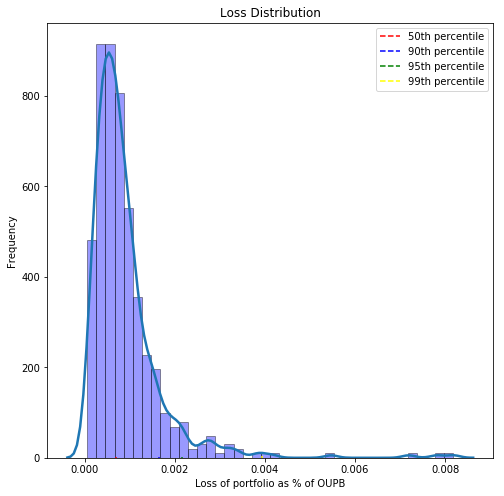

In [20]:
figure(figsize=(8,8))
sns.distplot(ave_loss,hist=True, kde=True, bins=40,hist_kws={'facecolor':'blue','edgecolor':'black'},kde_kws={'linewidth':2.5})
plt.vlines(result_dt.quantile(0.5), 0, 0.72, color = 'red', linestyles = 'dashed', label='50th percentile')
plt.vlines(result_dt.quantile(0.9), 0, 1.73, color = 'blue', linestyles = 'dashed', label='90th percentile')
plt.vlines(result_dt.quantile(0.95), 0, 2.26, color = 'green', linestyles = 'dashed', label='95th percentile')
plt.vlines(result_dt.quantile(0.99), 0, 3.92, color = 'yellow', linestyles = 'dashed', label='99th percentile')
plt.ylabel('Frequency')
plt.xlabel("Loss of portfolio as % of OUPB")
plt.title("Loss Distribution")

plt.legend()
#plt.show()


In [ ]:
# Knowing the 99th percentile losses
print(result_dt.quantile(0.50))
print(result_dt.quantile(0.90))
print(result_dt.quantile(0.95))
print(result_dt.quantile(0.99))
#result_dt.quantile(0.99)
result_dt = result_dt.sort_values(by=0)

In [22]:
result_dt

,0
0,0.000874
1,0.000387
2,0.000957
3,0.001845
4,0.001086
5,0.000418
6,0.001094
7,0.002747
8,0.000627
9,0.007191


In [23]:
result_dt.to_excel (r'C:\Users\DELL\Desktop\result_dt.xlsx', index = None, header=True)